In [18]:
#Basic imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

# Data Processing

In [19]:
# Import data
data = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)

In [20]:
def clean_data(df, del_col=[], mean=[], std=[]):
    X = df.copy()
    
    # Remove useless columns
    X = X.drop(['Patient ID', 'Batch Process ID'], axis=1)
    
    # Remove columns with only zeros
    if (len(del_col) == 0):
        del_col = (X != 0).any(axis=0)
    X = X.loc[:, del_col]
    
    # Replace zeros by nan
    X.replace(0, np.nan, inplace=True)
    
    # Replace nan values by mean of column
    if (len(mean) == 0 or len(std) == 0):
        mean = X.mean()
        std = X.std()
        std = std.fillna( 1)
    X = X.fillna(mean)
                 
    # Replace Sex labels by values
    X['Sex'].replace({0:'Male', 1:'Female'}, inplace=True)
    
    
    # Split Sex in Sex_Female and Sex_Male
    X = pd.get_dummies(X)
    
    # Categorical values
    cater = X[['Sex_Female', 'Sex_Male']]
    # Numerical values
    numer = X.drop(['Sex_Female', 'Sex_Male'], axis=1)
    
    #Scale each column in numer
    numer = (numer - mean)/std
    
    new_X = pd.concat([numer, cater], axis=1, join='inner')
    
    return new_X, del_col, mean, std

In [21]:
data_train, data_test, y_train, y_test = train_test_split(data.drop(['Age'], axis=1), data['Age'], test_size=0.3, random_state=42)

In [22]:
x_train, del_col, mean_train, std_train = clean_data(data_train)
x_test, _, _, _ = clean_data(data_test, del_col, mean_train, std_train)

### K-Means
Find optimal number of clusters based on training set

_Results_ : 3

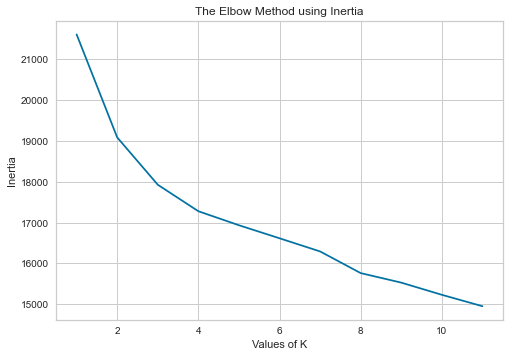

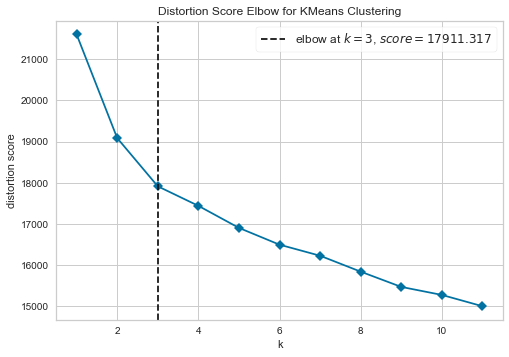

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
K = range(1, 12)
inertias = []
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(x_train)
    inertias.append(kmeanModel.inertia_)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=K, timings=False)

visualizer.fit(x_train)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Train a KMean model on training data with 3 clusters. Then clusterize training and test set according to it.

In [24]:
# Train K-Means with 3 clusters
kmeanModel = KMeans(n_clusters=3).fit(x_train.drop(['Cluster'], axis=1, errors='ignore'))

# Assign train samples to clusters
x_train['Cluster'] = kmeanModel.labels_

# Assign test samples to clusters
x_test['Cluster'] = kmeanModel.predict(x_test)

### PCA

In [25]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures

In [26]:
def sub_PCA(x, y, i):
    pca = PCA(n_components=0.85)
    pc = pca.fit_transform(x.drop(['Sex_Female', 'Sex_Male', 'Cluster'], axis=1))
    pc = pd.DataFrame(data = pc, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])
    
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title=f"% Cluster {i} - Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title=f"% Cluster {i} - Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=10, dpi=100)
    fig.show()
    
    mi_scores_PC = make_mi_scores(pc, y)
    mi_scores_feat = make_mi_scores(x, y)
    
    keep_features = mi_scores_feat[mi_scores_feat > 0].index.tolist()
    keep_PC = mi_scores_PC[mi_scores_PC > 0].index.tolist()
    
    return pca, pc, keep_features, keep_PC

In [27]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

### Submodel Training

In [28]:
def train_model(x, y):
    model = ElasticNet()
    #model = KernelRidge(kernel="rbf")
    #model = RandomForestRegressor(random_state=42)
    
    # Define model evaluation method
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

    # Define grid
    grid = {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
        'l1_ratio': np.logspace(-4, 0, 6)
    }
    
    #grid = {
        #'alpha': [1e0, 0.1, 1e-2, 1e-3],
        #'gamma': [1e0, 0.1, 1e-2, 1e-3]
    #}
    
    #grid = {
    #    'max_depth': [5, 10, 15]
    #}
    
    search = GridSearchCV(model, grid, cv=cv, n_jobs=1, scoring='neg_mean_absolute_error')
    search.fit(x,y)
    
    return search.best_estimator_, search.best_score_

In [29]:
def predict(model, x_train, x_test):
    # Predict age
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)
    
    return predict_train, predict_test

In [30]:
def plot_results(y_train, y_test, predict_train, predict_test, title):
    # Plot
    plt.figure(figsize=(10,10))
    plt.scatter(np.array(y_train, dtype='int'), predict_train, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(predict_train), max(np.array(y_train)))
    p2 = min(min(predict_train), min(np.array(y_train)))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('Train True Age', fontsize=15)
    plt.ylabel('Train Predicted Age', fontsize=15)
    plt.title(title)
    plt.axis('equal')
    plt.show()


     # Plot
    plt.figure(figsize=(10,10))
    plt.scatter(np.array(y_test, dtype='int'), predict_test, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(predict_test), max(np.array(y_test)))
    p2 = min(min(predict_test), min(np.array(y_test)))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('Test True Age', fontsize=15)
    plt.ylabel('Test Predicted Age', fontsize=15)
    plt.title(title)
    plt.axis('equal')
    plt.show()

In [31]:
def compute_score(y_train, y_test, predict_train, predict_test):
    # Compute error
    train_score = mean_absolute_error(y_train, predict_train)
    test_score = mean_absolute_error(y_test, predict_test)
    
    return train_score, test_score

In [38]:
def compute_r2(y_train, y_test, predict_train, predict_test):
    train_r2 = r2_score(y_train, predict_train)
    test_r2 = r2_score(y_test, predict_test)
    return train_r2, test_r2

### Run

-- Cluster 0 --
n_training_samples = 32
n_original_features = 143 | n_PC = 7
n_final_features = 150
best_score = -2.1535661460803546
train_score = 0.0005485430716274386
test_score = 3.1081856349707806
train_r2_score = 0.9999999523707908
test_r2_score = -0.3099359119076861
ElasticNet(alpha=0.0001, l1_ratio=1.0)



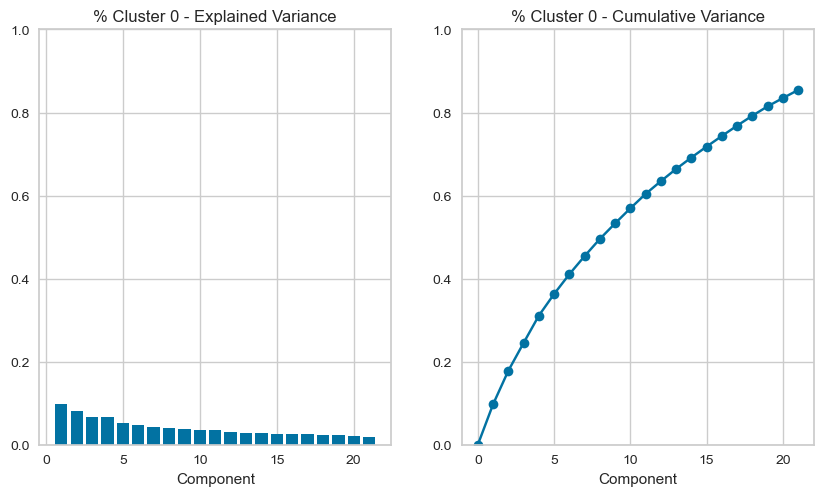

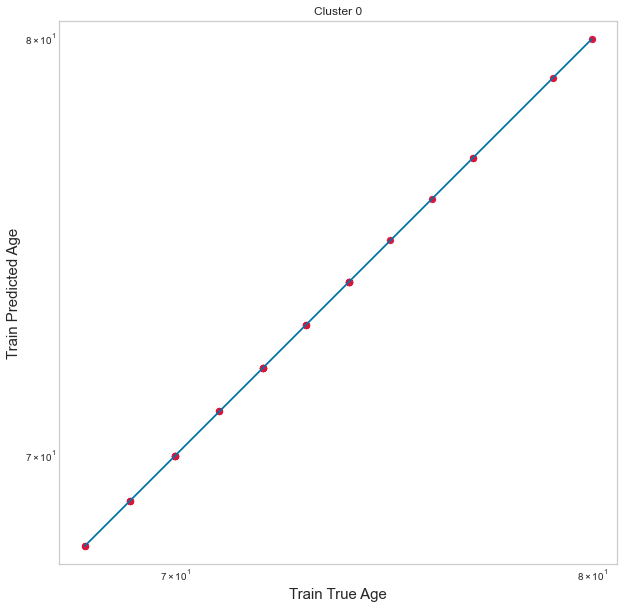

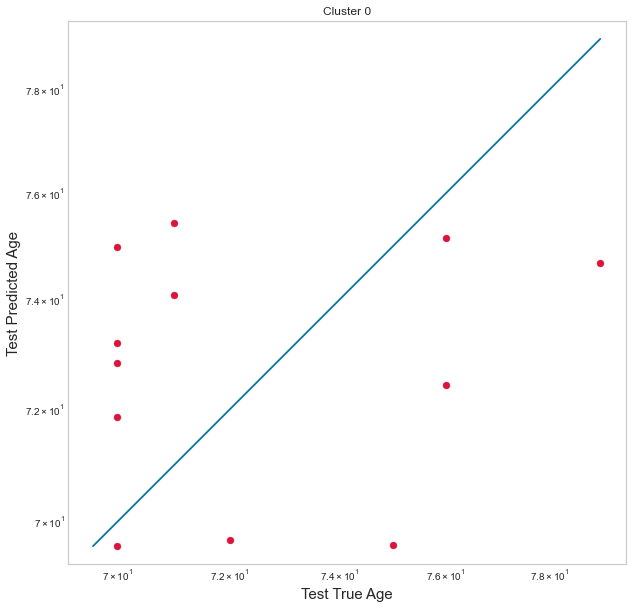

-- Cluster 1 --
n_training_samples = 22
n_original_features = 114 | n_PC = 7
n_final_features = 121
best_score = -2.0033851653800214
train_score = 0.005229084309197612
test_score = 3.4001579686178394
train_r2_score = 0.9999967762602849
test_r2_score = 0.023193847079687746
ElasticNet(alpha=0.01, l1_ratio=0.025118864315095822)



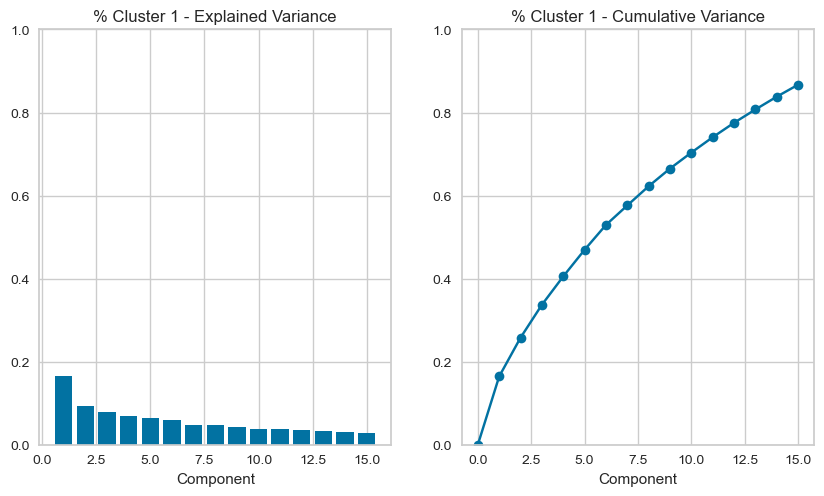

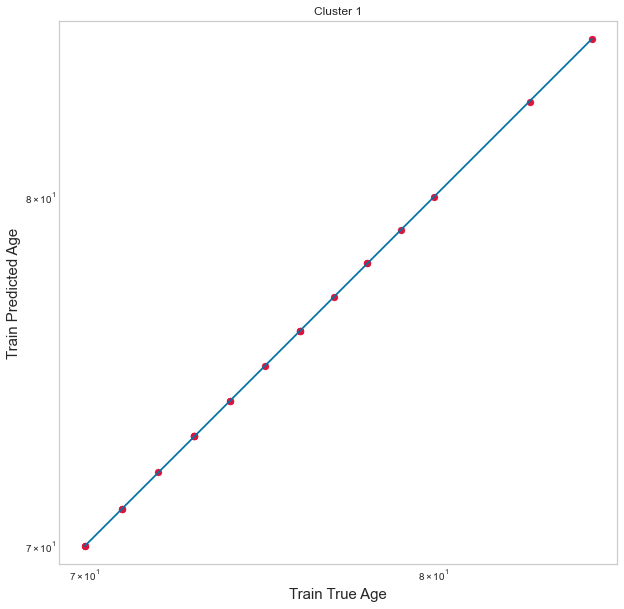

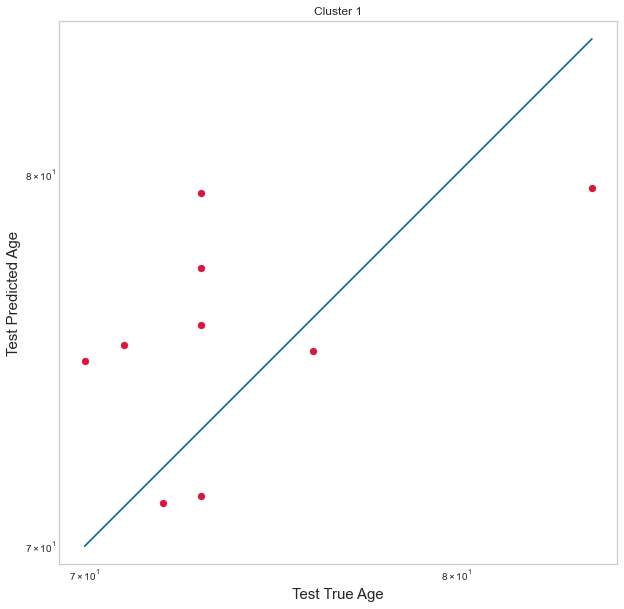

-- Cluster 2 --
n_training_samples = 39
n_original_features = 164 | n_PC = 11
n_final_features = 175
best_score = -2.6711218964395362
train_score = 0.005672774377263779
test_score = 3.266764864659721
train_r2_score = 0.9999954347843353
test_r2_score = -0.276988275515496
ElasticNet(alpha=0.001, l1_ratio=1.0)



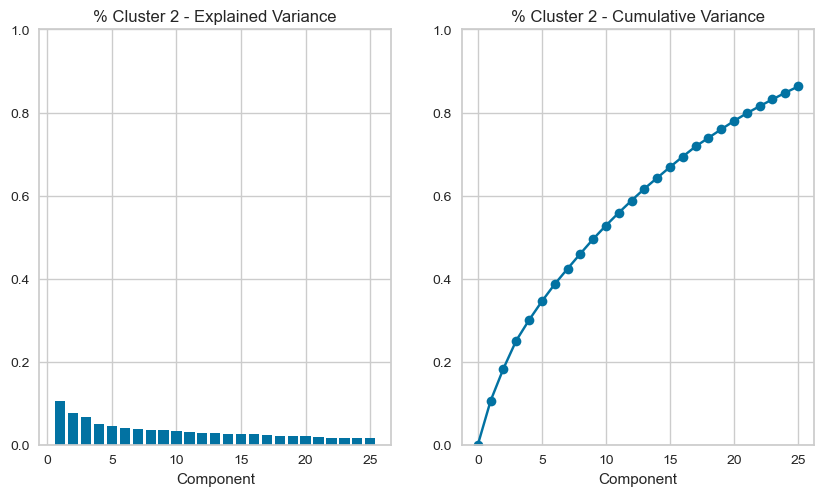

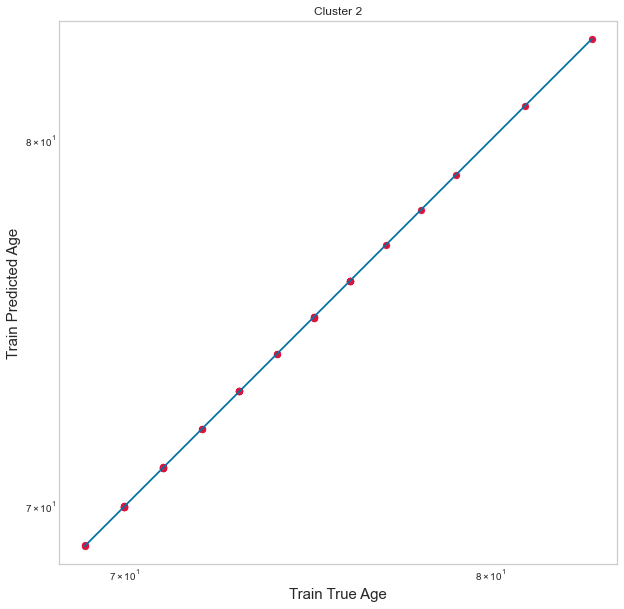

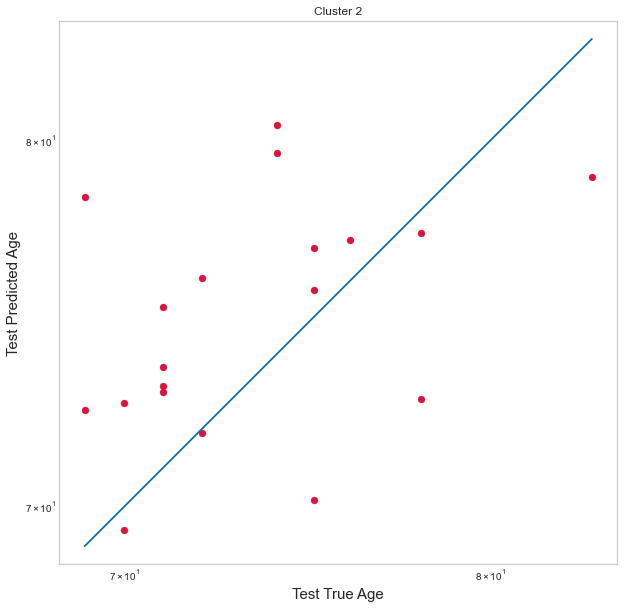

In [40]:
import warnings
warnings.filterwarnings('ignore') 

predicts_test = {}
predicts_train = {}
ys_test = {}
ys_train = {}

for i in [0, 1, 2]:
    idx_train = x_train['Cluster'] == i
    idx_test = x_test['Cluster'] == i
    
    # Get subsets of Cluster i
    sub_x_train = x_train[idx_train].reset_index().drop(['index'], axis=1)
    sub_x_test = x_test[idx_test].reset_index().drop(['index'], axis=1)
    sub_y_train = y_train[idx_train].reset_index().drop(['index'], axis=1)
    sub_y_test = y_test[idx_test].reset_index().drop(['index'], axis=1)
    
    # PCA on train set
    pca, pc, keep_features, keep_PC = sub_PCA(sub_x_train, sub_y_train, i)
    
    # Keep only PC with a MI score>0
    pc_train = pc[keep_PC]
    pc_test = pca.transform(sub_x_test.drop(['Sex_Female', 'Sex_Male', 'Cluster'], axis=1))
    pc_test = pd.DataFrame(data = pc_test, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])[keep_PC]

    # Concatenate polynomial features with principal components
    new_sub_x_train = pd.concat([sub_x_train[keep_features], pc_train], axis=1, join='inner')
    new_sub_x_test = pd.concat([sub_x_test[keep_features], pc_test], axis=1, join='inner')
    
    # Expand kept features to polynomial degree
    poly = PolynomialFeatures(1)
    # Keep only features with a MI score>0
    #poly_feat_train = pd.DataFrame(poly.fit_transform(sub_x_train[keep_features]))
    #poly_feat_test = pd.DataFrame(poly.fit_transform(sub_x_test[keep_features]))
    poly_feat_train = pd.DataFrame(poly.fit_transform(new_sub_x_train))
    poly_feat_test = pd.DataFrame(poly.fit_transform(new_sub_x_test))
    
    # Train model
    best_model, best_score = train_model(poly_feat_train, sub_y_train)
    
    # Compute predictions
    predict_train, predict_test = predict(best_model, poly_feat_train, poly_feat_test)
    
    # Compute MAE score
    train_score, test_score = compute_score(sub_y_train, sub_y_test, predict_train, predict_test)
    
    #Compute R2 score
    train_r2, test_r2 = compute_r2(sub_y_train, sub_y_test, predict_train, predict_test)
    
    # Print results
    print(f'-- Cluster {i} --')
    print(f'n_training_samples = {sub_y_train.shape[0]}')
    print(f'n_original_features = {len(keep_features)} | n_PC = {len(keep_PC)}')
    print(f'n_final_features = {poly_feat_train.shape[1] - 1}')
    print(f'best_score = {best_score}')
    print(f'train_score = {train_score}')
    print(f'test_score = {test_score}')
    print(f'train_r2_score = {train_r2}')
    print(f'test_r2_score = {test_r2}')
    print(f'ElasticNet(alpha={best_model.get_params()["alpha"]}, l1_ratio={best_model.get_params()["l1_ratio"]})\n')
    #print(f'KernelRidge(kernel="sigmoid", alpha={best_model.get_params()["alpha"]}, gamma={best_model.get_params()["gamma"]})\n')
    #print(f'RandomForest(max_depth={best_model.get_params()["max_depth"]})\n')
    
    plot_results(sub_y_train, sub_y_test, predict_train, predict_test, f'Cluster {i}')
    
    predicts_train[i] = predict_train
    predicts_test[i] = predict_test

In [ ]:
# Visualize all Clusters with a scatter plot
fig_global = plt.figure(figsize = (12,10))
ax_train = fig_global.add_subplot(1,1,1) 
ax_train.set_xlabel('Train True Age', fontsize = 15)
ax_train.set_ylabel('Train Predicted Age', fontsize = 15)

colors = ['r', 'g', 'b']
for i in [0, 1, 2]:
    idx = x_train['Cluster'] == i
    ax_train.scatter(y_train[idx], predicts_train[i], c = colors[i], s = 50)
p1 = max(max(np.concatenate([predicts_train[0], predicts_train[1], predicts_train[2]])), max(np.array(y_train)))
p2 = min(min(np.concatenate([predicts_train[0], predicts_train[1], predicts_train[2]])), min(np.array(y_train)))
plt.plot([p1, p2], [p1, p2], 'b-')
ax_train.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
ax_train.grid()

# Visualize Principal Components with a scatter plot
fig_global = plt.figure(figsize = (12,10))
ax_test = fig_global.add_subplot(1,1,1) 
ax_test.set_xlabel('Test True Age', fontsize = 15)
ax_test.set_ylabel('Test Predicted Age', fontsize = 15)

colors = ['r', 'g', 'b']
for i in [0, 1, 2]:
    idx = x_test['Cluster'] == i
    ax_test.scatter(y_test[idx], predicts_test[i], c = colors[i], s = 50)

p1 = max(max(np.concatenate([predicts_test[0], predicts_test[1], predicts_test[2]])), max(np.array(y_test)))
p2 = min(min(np.concatenate([predicts_test[0], predicts_test[1], predicts_test[2]])), min(np.array(y_test)))
plt.plot([p1, p2], [p1, p2], 'b-')
ax_test.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
ax_test.grid()

# Elastic
### PolyFeatures(deg=1) + PCA 85% variance

-- Cluster 0 --
n_training_samples = 19
n_original_features = 124 | n_PC = 4
n_final_features = 129
best_score = -1.9819853033349215
train_score = 0.004468581473106107
test_score = 3.5129000931403045
ElasticNet(alpha=0.01, l1_ratio=0.025118864315095822)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 132 | n_PC = 5
n_final_features = 138
best_score = -2.823116353198345
train_score = 0.004175456805387828
test_score = 2.445961858464053
ElasticNet(alpha=0.001, l1_ratio=1.0)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 138 | n_PC = 15
n_final_features = 154
best_score = -2.572849756497449
train_score = 0.002249136079182459
test_score = 2.6480107847629077
ElasticNet(alpha=0.001, l1_ratio=0.003981071705534973)


### PolyFeatures(deg=1) + PCA 85% variance + >0.2 MI_score

-- Cluster 0 --
n_training_samples = 19
n_original_features = 45 | n_PC = 1
n_final_features = 47
best_score = -1.889449771905129
train_score = 0.001955157183589874
test_score = 4.416081900966287
ElasticNet(alpha=0.001, l1_ratio=0.025118864315095822)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 40 | n_PC = 3
n_final_features = 44
best_score = -2.2545287849758346
train_score = 0.007448268376420073
test_score = 2.8218525131637477
ElasticNet(alpha=0.001, l1_ratio=1.0)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 33 | n_PC = 6
n_final_features = 40
best_score = -3.086990323359674
train_score = 1.3086335978267052
test_score = 2.66339829652213
ElasticNet(alpha=0.1, l1_ratio=1.0)

### PolyFeatures(deg=1) (PC + original features) + PCA 85% variance
#### Best
-- Cluster 0 --
n_training_samples = 19
n_original_features = 124 | n_PC = 4
n_final_features = 128
best_score = -1.981985303334921
train_score = 0.004468581473106107
test_score = 3.5129000931403045
ElasticNet(alpha=0.01, l1_ratio=0.025118864315095822)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 132 | n_PC = 5
n_final_features = 137
best_score = -2.823116353198345
train_score = 0.004175456805387301
test_score = 2.445961858464054
ElasticNet(alpha=0.001, l1_ratio=1.0)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 138 | n_PC = 15
n_final_features = 153
best_score = -2.5728497564974493
train_score = 0.002249136079182761
test_score = 2.6480107847629077
ElasticNet(alpha=0.001, l1_ratio=0.003981071705534973)

### PolyFeatures(deg=2) (PC + original features) + PCA 85% variance

-- Cluster 0 --
n_training_samples = 19
n_original_features = 124 | n_PC = 4
n_final_features = 8384
best_score = -2.0219692913623413
train_score = 1.2925880668783401e-05
test_score = 4.22788763661047
ElasticNet(alpha=0.001, l1_ratio=0.025118864315095822)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 132 | n_PC = 5
n_final_features = 9590
best_score = -2.519160292813891
train_score = 0.02322655476640252
test_score = 3.4683325750761584
ElasticNet(alpha=0.1, l1_ratio=0.15848931924611143)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 138 | n_PC = 15
n_final_features = 11934
best_score = -2.3823861155268227
train_score = 3.794015096985354e-06
test_score = 2.459604860974746
ElasticNet(alpha=0.001, l1_ratio=0.003981071705534973)

### PolyFeatures(deg=1) + PCA 85% variance + >0.1 MI score feature

-- Cluster 0 --
n_training_samples = 19
n_original_features = 45 | n_PC = 4
n_final_features = 49
best_score = -1.9945179590925495
train_score = 0.0018732610648397128
test_score = 4.464927392144729
ElasticNet(alpha=0.001, l1_ratio=0.15848931924611143)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 40 | n_PC = 5
n_final_features = 45
best_score = -2.4707162714092457
train_score = 0.0073565381711781
test_score = 2.991576775695527
ElasticNet(alpha=0.001, l1_ratio=1.0)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 33 | n_PC = 15
n_final_features = 48
best_score = -2.8614145933592545
train_score = 0.93492924000202
test_score = 2.289366240349404
ElasticNet(alpha=0.1, l1_ratio=0.15848931924611143)

# Kernel Ridge Sigmoid

### PolyFeatures(deg=1)  + PCA 85% variance

-- Cluster 0 --
n_training_samples = 19
n_original_features = 45 | n_PC = 4
n_final_features = 49
best_score = -2.302939763211354
train_score = 0.8578367737851088
test_score = 3.534413876400043
KernelRidge(kernel="sigmoid", alpha=0.01, gamma=0.001)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 40 | n_PC = 5
n_final_features = 45
best_score = -2.6741099292123627
train_score = 2.190888804508946
test_score = 3.1087942112028615
KernelRidge(kernel="sigmoid", alpha=0.1, gamma=0.001)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 33 | n_PC = 15
n_final_features = 48
best_score = -2.2101728908407354
train_score = 1.784113425475101
test_score = 2.466246444773531
KernelRidge(kernel="sigmoid", alpha=0.1, gamma=0.001)

# Random Forest

### PolyFeatures(deg=1)  + PCA 85% variance

-- Cluster 0 --
n_training_samples = 19
n_original_features = 45 | n_PC = 4
n_final_features = 49
best_score = -3.1125833333333337
train_score = 1.1160526315789472
test_score = 3.8128125000000015
RandomForest(max_depth=5)

-- Cluster 1 --
n_training_samples = 27
n_original_features = 40 | n_PC = 5
n_final_features = 45
best_score = -2.3800934126984123
train_score = 1.0644876543209874
test_score = 2.7956818181818206
RandomForest(max_depth=5)

-- Cluster 2 --
n_training_samples = 47
n_original_features = 33 | n_PC = 15
n_final_features = 48
best_score = -2.2657791996902974
train_score = 0.8579942599308769
test_score = 2.5637775137142285
RandomForest(max_depth=5)